### 필요한 라이브러리 설치

In [ ]:
!pip install lief
!pip install numpy
!pip install sklearn
!pip install tqdm
!pip install graphviz
!pip install lightgbm

     |████████████████████████████████| 3.5MB 5.9MB/s 


### 구글 드라이브 연동

In [ ]:
from google.colab import drive 
drive_path = '/content/gdrive/'
drive.mount(drive_path)

import sys
sys.path.append(drive_path + "My Drive")

Mounted at /content/gdrive/


## 피처 추출 코드
- https://bit.ly/3gWqxuj

## 학습 데이터
- https://bit.ly/2FkqtXn

## 학습 라벨
- https://bit.ly/3amlIYV

## 검증 데이터
- https://bit.ly/2PMXPQO

## 검증 라벨
- https://bit.ly/2XYGbOe


In [ ]:
import glob
import os
import pickle
import ember

import pandas as pd
import numpy as np

from pprint import pprint
from tqdm.notebook import tqdm

from sklearn import tree

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

%matplotlib inline

### EMBER 코드로 피처 추출

In [ ]:
def read_bytes(path):
    with open(path, "rb") as f:
        return f.read()


In [ ]:
example_path = os.path.join(drive_path, "My Drive", "sample.exe")

raw = read_bytes(example_path)
generator = ember.PEFeatureExtractor()

generator.raw_features(raw)

In [ ]:
generator.feature_vector(raw)

array([1.8832208e-01, 2.5478901e-02, 1.7842956e-02, ..., 1.6426400e+05,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [ ]:
def read_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)


### 데이터 로드

In [ ]:
X_train = read_pickle(os.path.join(drive_path, "My Drive", "ember_train_features.pkl"))
y_train = read_pickle(os.path.join(drive_path, "My Drive", "ember_train_labels.pkl"))

X_test = read_pickle(os.path.join(drive_path, "My Drive", "ember_test_features.pkl"))
y_test = read_pickle(os.path.join(drive_path, "My Drive", "ember_test_labels.pkl"))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(20000, 2381)
(20000,)
(20000, 2381)
(20000,)


### 학습 및 테스트

In [ ]:
def load_model(**kwargs):
    if kwargs["model"] == "rf":
        return RandomForestClassifier(random_state=kwargs["random_state"], n_jobs=4)
    elif kwargs["model"] == "dt":
        return DecisionTreeClassifier(random_state=kwargs["random_state"])
    elif kwargs["model"] == "lgb":
        return LGBMClassifier(random_state=kwargs["random_state"])
    elif kwargs["model"] == "svm":
        return SVC(random_state=kwargs["random_state"])
    elif kwargs["model"] == "lr":
        return LogisticRegression(random_state=kwargs["random_state"], n_jobs=-1)
    elif kwargs["model"] == "knn":
        return KNeighborsClassifier(n_jobs=-1)
    elif kwargs["model"] == "adaboost":
        return AdaBoostClassifier(random_state=kwargs["random_state"])
    elif kwargs["model"] == "mlp":
        return MLPClassifier(random_state=kwargs["random_state"])
    else:
        print("Unsupported Algorithm")
        return None

SEED = 41
clf = load_model(model="lgb", random_state=SEED)
clf.fit(X_train, y_train)

predict = clf.predict(X_test)

print("accuracy", clf.score(X_test, y_test))
print("precision", precision_score(y_test, predict))
print("recall", recall_score(y_test, predict))
print("f1-score", f1_score(y_test, predict))

accuracy 0.95505
precision 0.9739190591490834
recall 0.9642465753424657
f1-score 0.9690586818103596


### 특징 중요도 그래프

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

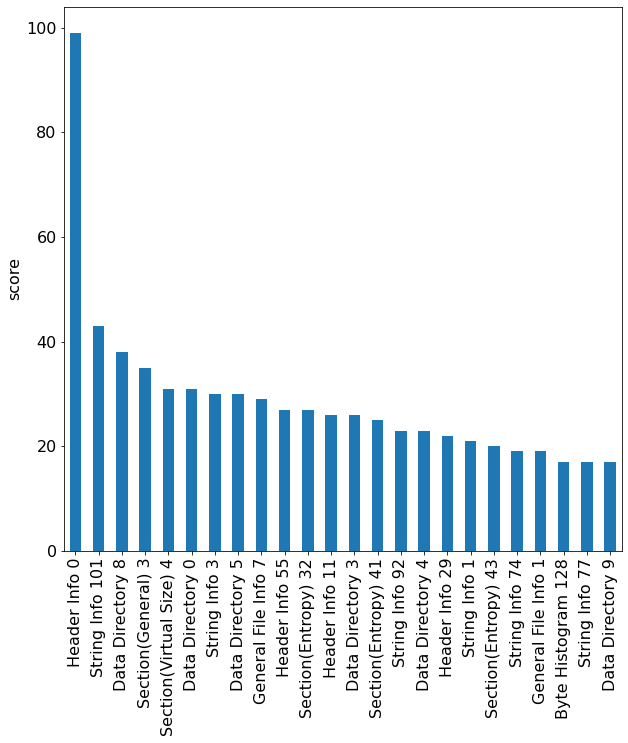

In [ ]:
section, dll, function, eat = 50, 256, 1024, 128    

header = [f"Byte Histogram {i}" for i in range(256)] +\
[f"Byte Entropy Histogram {i}" for i in range(256)] +\
[f"String Info {i}" for i in range(104)]+\
[f"General File Info {i}" for i in range(10)]+\
[f"Header Info {i}" for i in range(62)]+\
[f"Section(General) {i}" for i in range(5)]+\
[f"Section(Size) {i}" for i in range(section)]+\
[f"Section(Entropy) {i}" for i in range(section)]+\
[f"Section(Virtual Size) {i}" for i in range(section)]+\
[f"Section(Entry) {i}" for i in range(section)]+\
[f"Section(Characteristic) {i}" for i in range(section)]+\
[f"Imports(DLL) {i}" for i in range(dll)]+\
[f"Imports(Function) {i}" for i in range(function)]+\
[f"Exports(Function) {i}" for i in range(eat)]+\
[f"Data Directory {i}" for i in range(30)]



plt.figure(figsize=(10, 10))
feat_importances = pd.Series(clf.feature_importances_, index=header)
feat_importances.nlargest(24).plot(kind='bar')
plt.ylabel("score", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)




### 판별 분기

In [ ]:

for dtree in clf.estimators_[:1]:
    tree.export_graphviz(dtree
                            , max_depth=2
                            , out_file='tree.dot'
                            , feature_names=header
                            , class_names=['benign', 'mal']
                            , filled=True
                            , rounded=True
                            , special_characters=True)

    # Convert to png using system command (requires Graphviz)
    os.system('dot ' + '-Tpng ' + 'tree.dot ' + '-o ' + 'tree.png ')

### 혼동 행렬

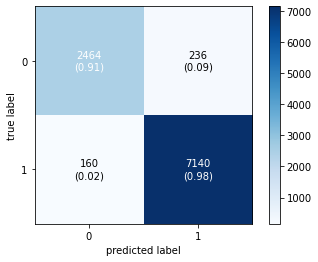

In [ ]:
disp = plot_confusion_matrix(clf, X_test, y_test, normalize="true", cmap=plt.cm.Blues)
disp.figure_.savefig("실험3 Ember")


### 최적 파라미터 탐색 (Grid Search)

In [ ]:
print("현재 랜덤포레스트 파라미터")
pprint(clf.get_params())

현재 랜덤포레스트 파라미터
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 4,
 'oob_score': False,
 'random_state': 41,
 'verbose': 0,
 'warm_start': False}


In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110, None],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 128, 256, 1024]
}
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=2)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 60.9min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 107.3min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 169.7min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 246.8min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 307.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=4,
                                              oob_score=False, random_state=41,
                                     

In [ ]:
pprint(grid_search.best_params_)

best_grid = grid_search.best_estimator_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 128}


In [ ]:
clf.set_params(**grid_search.best_params_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=4,
                       oob_score=False, random_state=41, verbose=0,
                       warm_start=False)

In [ ]:
best_grid.score(X_test, y_test)

0.9311